Name: Amirhossein Safari \
ID: 14014121

In this notebook, we will be building and training LSTM and GRU to predict the stock market. You do not allow to use TensorFlow and Keras libraries.

## 1. Libraries and settings

In [2]:
# Import libraries 
# Notice that it is important that which libraries you use, so you should import
# libraries just here in your code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.autograd import Variable

## 2. Load data

In [4]:
# Read data 
df = pd.read_csv('time_series.csv')
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.NVDA,D,20101004,0,11.24,11.430,11.01,11.23,18184874
1,US1.NVDA,D,20101005,0,11.48,11.500,11.29,11.32,18266877
2,US1.NVDA,D,20101006,0,11.32,11.370,10.67,10.78,25753399
3,US1.NVDA,D,20101007,0,10.82,10.840,10.38,10.70,18732301
4,US1.NVDA,D,20101008,0,10.65,10.950,10.51,10.86,16998198
...,...,...,...,...,...,...,...,...,...
2762,US1.NVDA,D,20210927,0,217.16,217.750,213.28,216.57,625939
2763,US1.NVDA,D,20210928,0,212.01,214.030,206.51,207.02,835341
2764,US1.NVDA,D,20210929,0,209.33,210.160,204.68,205.22,606902
2765,US1.NVDA,D,20210930,0,207.89,210.650,206.89,207.12,537697


In [5]:
features = []
for feature in df.columns:
  if feature not in ["<TICKER>", "<PER>"] :
    features.append(feature)

In [6]:
features

['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']

In [7]:
df = df[features]

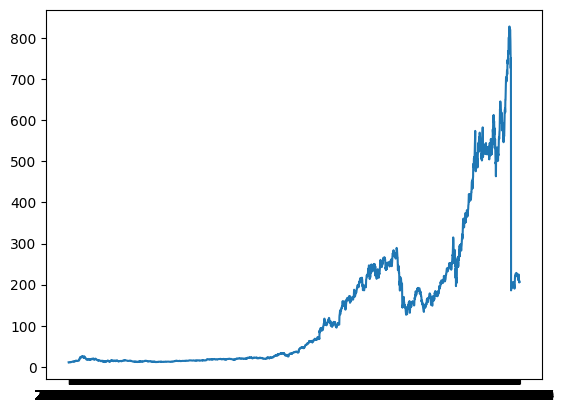

In [8]:
# Plot close prices ("<CLOSE>") based on dates ("<DATE>")

date = df["<DATE>"].to_numpy()
date = [str(d) for d in date]

close = df["<CLOSE>"].to_numpy()

plt.plot(date, close)

In [9]:
data = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data)
df = pd.DataFrame(x_scaled)

In [10]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2166, 59, 7)
y_train.shape =  (2166, 7)
x_test.shape =  (541, 59, 7)
y_test.shape =  (541, 7)


In [11]:
x_train

array([[[0.00000000e+00, 0.00000000e+00, 7.16071559e-04, ...,
         7.83747807e-04, 6.48508431e-04, 2.14558137e-01],
        [9.09115704e-06, 0.00000000e+00, 1.00735490e-03, ...,
         1.13208017e-03, 7.58632504e-04, 2.15529746e-01],
        [1.81823141e-05, 0.00000000e+00, 8.13166007e-04, ...,
         3.60772800e-04, 9.78880650e-05, 3.04233503e-01],
        ...,
        [1.98187223e-03, 0.00000000e+00, 5.08532175e-03, ...,
         5.37427068e-03, 5.29819152e-03, 1.37176152e-01],
        [1.99096339e-03, 0.00000000e+00, 5.30378426e-03, ...,
         5.57331774e-03, 5.15135942e-03, 7.74885502e-02],
        [2.02732802e-03, 0.00000000e+00, 5.09745855e-03, ...,
         5.26230671e-03, 5.26148349e-03, 7.36563434e-02]],

       [[9.09115704e-06, 0.00000000e+00, 1.00735490e-03, ...,
         1.13208017e-03, 7.58632504e-04, 2.15529746e-01],
        [1.81823141e-05, 0.00000000e+00, 8.13166007e-04, ...,
         3.60772800e-04, 9.78880650e-05, 3.04233503e-01],
        [2.72734711e-05, 

## 3. Build the structure of models

In [12]:
# Build model
#####################
# you can change these parameters to get better result
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

# Set the random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Propagate input through the LSTM layers
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output of the last time step through the linear layer
        out = self.fc(out[:, -1, :])

        return out
    
    def backward(self, optimizer, criterion, inputs, labels):
        optimizer.zero_grad()  # Clear gradients
        outputs = self.forward(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        return loss.item()


class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Propagate input through the GRU layers
        out, _ = self.gru(x, h0)

        # Pass the output of the last time step through the linear layer
        out = self.fc(out[:, -1, :])

        return out

    def backward(self, optimizer, criterion, inputs, labels):
        optimizer.zero_grad()  # Clear gradients
        outputs = self.forward(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        return loss.item()
        

In [13]:
X_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

In [14]:
# Train models
# Build and train the LSTM model
lstm_model = LSTM(input_dim=7, hidden_dim=32, num_layers=2, output_dim=7)
lstm_criterion = nn.MSELoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    lstm_loss = lstm_model.backward(lstm_optimizer, lstm_criterion, X_train, y_train)
    print('LSTM - Epoch {}/{}, Loss: {:.4f}'.format(epoch + 1, 100, lstm_loss))

LSTM - Epoch 1/100, Loss: 0.0443
LSTM - Epoch 2/100, Loss: 0.0222
LSTM - Epoch 3/100, Loss: 0.0151
LSTM - Epoch 4/100, Loss: 0.0163
LSTM - Epoch 5/100, Loss: 0.0122
LSTM - Epoch 6/100, Loss: 0.0118
LSTM - Epoch 7/100, Loss: 0.0123
LSTM - Epoch 8/100, Loss: 0.0114
LSTM - Epoch 9/100, Loss: 0.0092
LSTM - Epoch 10/100, Loss: 0.0067
LSTM - Epoch 11/100, Loss: 0.0058
LSTM - Epoch 12/100, Loss: 0.0063
LSTM - Epoch 13/100, Loss: 0.0039
LSTM - Epoch 14/100, Loss: 0.0040
LSTM - Epoch 15/100, Loss: 0.0048
LSTM - Epoch 16/100, Loss: 0.0042
LSTM - Epoch 17/100, Loss: 0.0037
LSTM - Epoch 18/100, Loss: 0.0040
LSTM - Epoch 19/100, Loss: 0.0033
LSTM - Epoch 20/100, Loss: 0.0026
LSTM - Epoch 21/100, Loss: 0.0026
LSTM - Epoch 22/100, Loss: 0.0028
LSTM - Epoch 23/100, Loss: 0.0029
LSTM - Epoch 24/100, Loss: 0.0028
LSTM - Epoch 25/100, Loss: 0.0028
LSTM - Epoch 26/100, Loss: 0.0028
LSTM - Epoch 27/100, Loss: 0.0027
LSTM - Epoch 28/100, Loss: 0.0025
LSTM - Epoch 29/100, Loss: 0.0023
LSTM - Epoch 30/100, Lo

In [15]:
# Build and train the GRU model
gru_model = GRU(input_dim=7, hidden_dim=32, num_layers=2, output_dim=7)
gru_criterion = nn.MSELoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)

for epoch in range(100):
    gru_loss = gru_model.backward(gru_optimizer, gru_criterion, X_train, y_train)
    print('GRU - Epoch {}/{}, Loss: {:.4f}'.format(epoch + 1, 100, gru_loss))


GRU - Epoch 1/100, Loss: 0.0678
GRU - Epoch 2/100, Loss: 0.0235
GRU - Epoch 3/100, Loss: 0.0192
GRU - Epoch 4/100, Loss: 0.0175
GRU - Epoch 5/100, Loss: 0.0134
GRU - Epoch 6/100, Loss: 0.0104
GRU - Epoch 7/100, Loss: 0.0088
GRU - Epoch 8/100, Loss: 0.0079
GRU - Epoch 9/100, Loss: 0.0068
GRU - Epoch 10/100, Loss: 0.0055
GRU - Epoch 11/100, Loss: 0.0049
GRU - Epoch 12/100, Loss: 0.0046
GRU - Epoch 13/100, Loss: 0.0042
GRU - Epoch 14/100, Loss: 0.0038
GRU - Epoch 15/100, Loss: 0.0035
GRU - Epoch 16/100, Loss: 0.0033
GRU - Epoch 17/100, Loss: 0.0031
GRU - Epoch 18/100, Loss: 0.0030
GRU - Epoch 19/100, Loss: 0.0030
GRU - Epoch 20/100, Loss: 0.0030
GRU - Epoch 21/100, Loss: 0.0030
GRU - Epoch 22/100, Loss: 0.0028
GRU - Epoch 23/100, Loss: 0.0026
GRU - Epoch 24/100, Loss: 0.0024
GRU - Epoch 25/100, Loss: 0.0022
GRU - Epoch 26/100, Loss: 0.0022
GRU - Epoch 27/100, Loss: 0.0022
GRU - Epoch 28/100, Loss: 0.0021
GRU - Epoch 29/100, Loss: 0.0020
GRU - Epoch 30/100, Loss: 0.0018
GRU - Epoch 31/100,

Epoch 1/100, LSTM Loss: 0.0008, GRU Loss: 0.0006
Epoch 2/100, LSTM Loss: 0.0008, GRU Loss: 0.0006
Epoch 3/100, LSTM Loss: 0.0008, GRU Loss: 0.0006
Epoch 4/100, LSTM Loss: 0.0008, GRU Loss: 0.0006
Epoch 5/100, LSTM Loss: 0.0008, GRU Loss: 0.0006
Epoch 6/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 7/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 8/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 9/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 10/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 11/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 12/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 13/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 14/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 15/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 16/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 17/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 18/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 19/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 20/100, LSTM Loss: 0.0007, GRU Loss: 0.0006
Epoch 21/

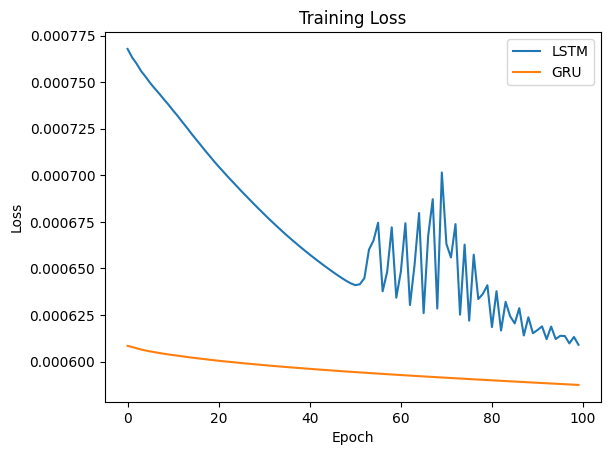

In [16]:
# Plot loss based on epochs

# Initialize lists to store losses
lstm_losses = []
gru_losses = []

for epoch in range(100):
    lstm_loss = lstm_model.backward(lstm_optimizer, lstm_criterion, X_train, y_train)
    lstm_losses.append(lstm_loss)

    gru_loss = gru_model.backward(gru_optimizer, gru_criterion, X_train, y_train)
    gru_losses.append(gru_loss)

    print('Epoch {}/{}, LSTM Loss: {:.4f}, GRU Loss: {:.4f}'.format(epoch + 1, 100, lstm_loss, gru_loss))

# Plot the loss
plt.plot(range(len(lstm_losses)), lstm_losses, label='LSTM')
plt.plot(range(len(gru_losses)), gru_losses, label='GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [17]:
# make predictions

X_test = torch.from_numpy(x_test).float()

# Set models to evaluation mode
lstm_model.eval()
gru_model.eval()

# Make predictions using the LSTM model
with torch.no_grad():
    lstm_predictions = lstm_model(X_test)

# Make predictions using the GRU model
with torch.no_grad():
    gru_predictions = gru_model(X_test)

# Convert predictions to numpy arrays
lstm_predictions = lstm_predictions.numpy()
gru_predictions = gru_predictions.numpy()

# Calculate root mean squared error

# Calculate RMSE for LSTM predictions
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))

# Calculate RMSE for GRU predictions
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))

# Print the RMSE values
print('LSTM RMSE:', lstm_rmse)
print('GRU RMSE:', gru_rmse)

LSTM RMSE: 0.10975702262709838
GRU RMSE: 0.055257968497047213


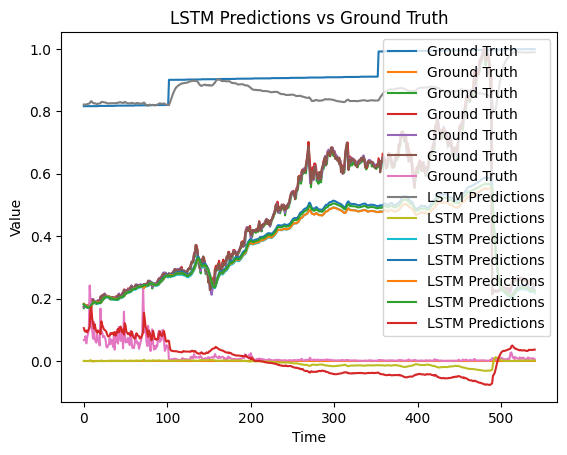

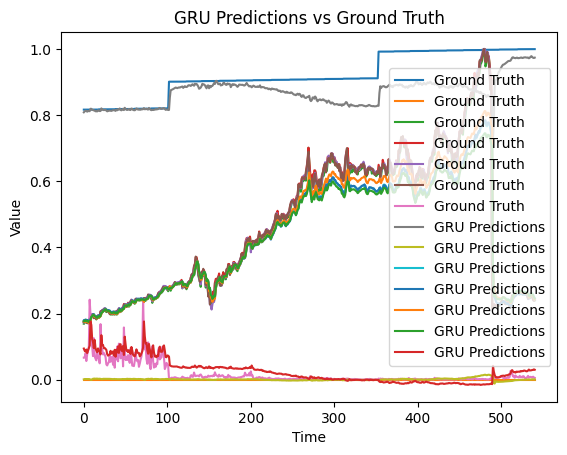

In [18]:
# Visualising the prediction results and compare LSTM and GRU models

# Define the x-axis values for plotting
x_axis = range(len(y_test))

# Plot the ground truth and predictions for LSTM
plt.plot(x_axis, y_test, label='Ground Truth')
plt.plot(x_axis, lstm_predictions, label='LSTM Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Predictions vs Ground Truth')
plt.legend()
plt.show()

# Plot the ground truth and predictions for GRU
plt.plot(x_axis, y_test, label='Ground Truth')
plt.plot(x_axis, gru_predictions, label='GRU Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GRU Predictions vs Ground Truth')
plt.legend()
plt.show()